## Introduction

In this notebook, we will use the model proposed in the given [paper](https://www.medrxiv.org/content/10.1101/2020.03.21.20040154v1.full.pdf) and create a simulation for Turkey by using the data provided by [who](https://covid19.who.int).

## Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit
from scipy.integrate import odeint, solve_ivp
import math

## Loading Data
In the following cells, we will load and extract needed information from the data. Then, we will visualize the confirmed cumulative cases.

In [2]:
df = pd.read_csv('WHO-COVID-19-global-data.csv')

In [3]:
df_turkey = df.loc[df[' Country'] == "Turkey"]

In [4]:
len(df_turkey[' Cumulative_cases'].values )

156

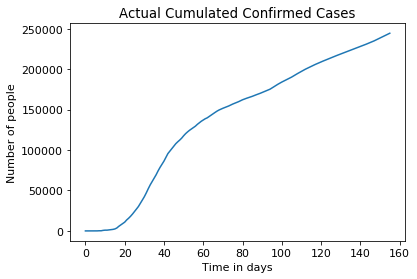

In [5]:
y = df_turkey[' Cumulative_cases'].values[0:len(df_turkey[' Cumulative_cases'].values )]

turkey_plt = plt.figure()
plt.rcParams.update({'font.size':11})
plt.plot(y ,label="Actual Cases")
plt.xlabel("Time in days")
plt.ylabel("Number of people")
plt.title("Actual Cumulated Confirmed Cases")

plt.savefig('cumulative confirmed cases.png')

### Clearing the noise and fit the data for early days of the epidemic
By using clean data, we will calculate $x_1$, $x_2$, and $x_3$ 

In [6]:
def fit(x, a, b):
  return a * np.exp(b * x)

In [7]:
y=df_turkey[' Cumulative_cases'].values[0:45]
x=np.arange(1,len(y)+1)

popt, pcov = curve_fit(fit, x, y)

Text(0, 0.5, 'Number of people')

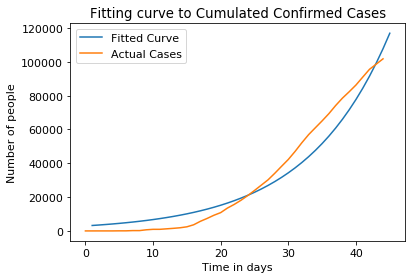

In [8]:
turkey_fit=plt.figure()
plt.plot(x, fit(x, *popt), label="Fitted Curve")
plt.plot(y, label="Actual Cases")
plt.legend(loc="upper left")

plt.title("Fitting curve to Cumulated Confirmed Cases")
plt.xlabel('Time in days')
plt.ylabel('Number of people')

This curve will help us in finding;
* the beginning point of the epidemic : $t_0$
* the number of asymptomatic infectious at time $t_0$ : $I_0$
* the number of unreported symptomatic infectious at time $t_0$ : $U_0$
* the rate of transmission : $\tau$

In [9]:
popt

array([2.96995987e+03, 8.16229510e-02])

## Estimating Parameters
v = $v_1$ + $v_2$ : The rate at which asymptotic individuals become symptotic individuals

n : The rate at which reported/unreported symptotic individuals get recovered

f : Fraction of asymptomatic infectious individuals that become reported symptomatic infectious individuals

$x_1$ and $x_2$ will be calculated from the fitted curve (model assumes that $x_3 = 1$)

In [10]:
v = 1/7
n = 1/7
f1 = 0.6 # means that 20% of symptomatic infectious cases go unreported (sugested in the paper)
f2 = 0.9 # means that 10% of symptomatic infectious cases go unreported (after the adoption of aggressive testing)

In [11]:
x1 = popt[0]
x2 = popt[1]
#x3 = abs(popt[2])
x1, x2 # we can assumed x3 = 1 as like the paper

(2969.959868791433, 0.08162295104310989)

In [12]:
t0 = 1/x2 - math.log(x1) # the initial time for the beginning of the early exponential growth phase 
# t0 = (math.log(x3/x1))/x2
t0

4.255152362634262

In the next cell, we will calculate or set;
* $S_0$ : number of susceptible at time $t_0$ (basically the entire population of the given country)
* $I_0$ : number of asymptomatic infectious at time $t_0$
* $U_0$ : number of unreported symptomatic infectious at time $t_0$
* $\tau_0$ : transmission rate at time $t_0$
* $R_0$ : number of reported infectious individual at time $t_0$
* $CR_0$ : number of cumulative reported cases at time $t_0$
* $CU_0$ : number of cumulative unreported cases at time $t_0$

In [13]:
S0 = 82000000

I0 = x2/f1*v
U0 = (1-f1)*v*I0/(n+x2)
tau0 = (x2+v)*(n+x2)/(S0*(n+x2+(1-f1)*v))
R0 = 0
CR0 = 0
CU0 = 0
DR0 = 0
#I0 = x2*x3/f1*v
#U0 = (1-f1)*v*I0/(n+x2)
#tau0 = (x2+v)*(n+x2)/(S0*(n+x2+(1-f1)*v))
I0 , U0 , tau0

(0.019434035962645212, 0.004947059320173124, 2.1820955985446324e-09)

In [14]:
# The value of basic reproductive number can be calculated via the following function

def repronum(tau0, S0, v, f, n):
    return ((tau0*S0)/(v))*(1 + ((1-f)*v)/n)

# The reproductive number for our data is calculated below

curly_R0 = repronum(tau0, S0, v, f1, n)
curly_R0

1.7535320229904665

First confirmed case in Turkey happened in March 8. At March 12, Turkey started to implement some small measures. Major public health interventions such as total curfew for who are over age 65 or chronically ill etc started on March 20. Taking into account the speed of Turkish bureaucracy, we choose N=25 here.

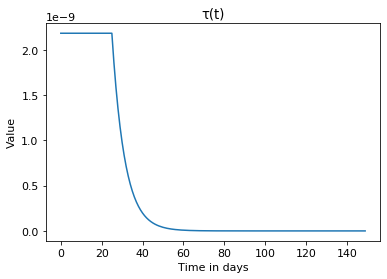

In [15]:
N = 25
mu = 0.16 # value used in the paper
def tau(t, N, mu):
    if t<N:
        return tau0
    else:
        return tau0 * math.exp(-mu * (t-N))

vtau = np.vectorize(tau)
d = np.arange(0.0, 150.0, 1)
T = vtau(d, N, mu)
plt.title("τ(t)")
plt.xlabel('Time in days')
plt.ylabel('Value')
plt.plot (d, T)

plt.savefig('tau.png')

## Deploying and Visualizing the Model

Here instead of using $\tau(t)$ provided above, we will use following function for coding simplicity;

$$ \tau(t)=\left\{
\begin{array}{ll}
      \tau_0 & if & t \leq N \\
      0 & if & t>N\\
\end{array} 
\right.$$

This will give roughly the same result.

Also our value f will increase to 0.9 after proper public health interventions which can be interpreted as the number of cases go unreported reduced to 0.1 after these interventions.

In [16]:
actual = df_turkey[' Cumulative_cases'].values
t = np.linspace(0, 74, 74)

In [17]:
# list of ordinary differential equations
def odes(y, t, tau, v, n, f):
    
    S, I, R, U, CR, CU, DR = y
    dS = -tau * S * (I + U)
    dI = tau * S * (I + U) - v * I
    dR = v * f * I - n * R
    dU = (1 - f) * v * I - n * U
    dCR = f * v * I
    dCU = (1 - f) * v * I
    dDR = v * f * I - DR
    
    return dS, dI, dR, dU, dCR, dCU, dDR
    

In [18]:
y0 = S0, I0, R0, U0, CR0, CU0, DR0
sol = odeint(odes, y0, t, args = (tau0 ,v, n, f1))
S, I, R, U, CR, CU, DR = sol.T

In [19]:
y1 = S[-1], I[-1], R[-1], U[-1], CR[-1], CU[-1], DR[-1]
tau0 = 0
t = np.linspace(0, 126, 126)
sol1 = odeint(odes, y1, t, args = (tau0 ,v, n, f2))
S1, I1, R1, U1, CR1, CU1, DR1 = sol1.T

In [20]:
s = np.concatenate((S, S1))
i = np.concatenate((I, I1))
r = np.concatenate((R, R1))
u = np.concatenate((U, U1))
cr = np.concatenate((CR, CR1))
cu = np.concatenate((CU, CU1))
dr = np.concatenate((DR, DR1))

## Plot the data for the model

In [21]:
t = np.linspace(0, 200, 200)

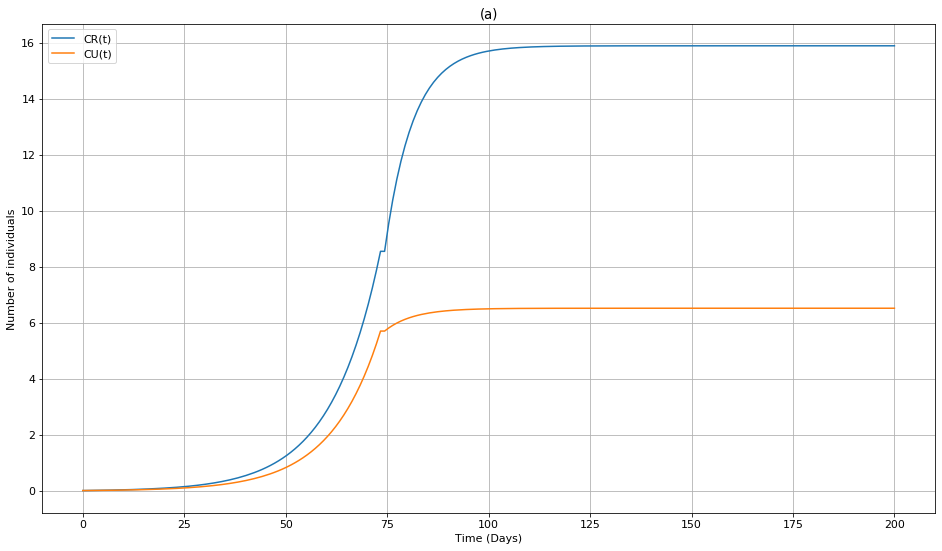

In [22]:
plt.rcParams['figure.figsize'] = 16, 9       # Aspect ratio of the figures

plt.figure()
plt.plot(t, cr, label = "CR(t)")
plt.plot(t, cu, label = "CU(t)")
plt.grid()
plt.xlabel("Time (Days)")
plt.ylabel("Number of individuals")
plt.title("(a)")
plt.legend(loc = 0)

plt.savefig('cr_cu.png')

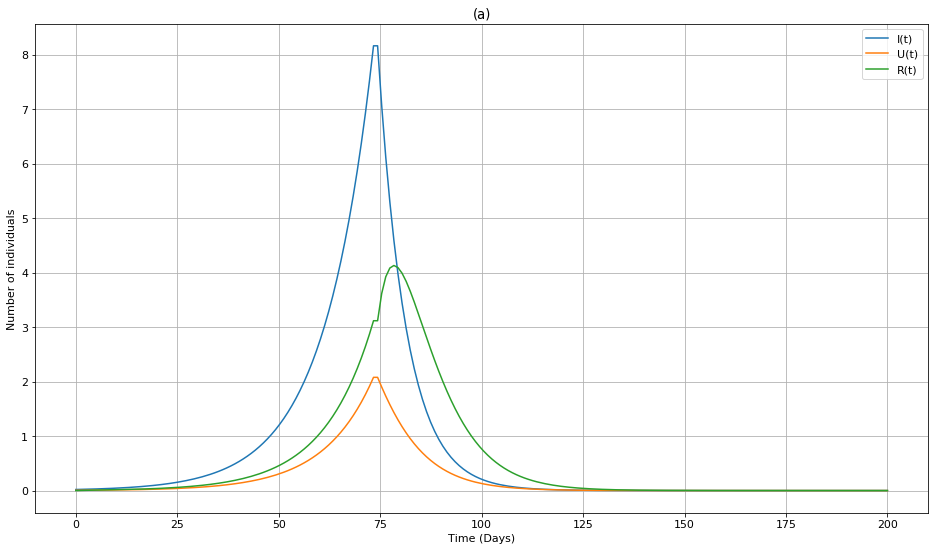

In [23]:
plt.rcParams['figure.figsize'] = 16, 9       # Aspect ratio of the figures

plt.figure()
plt.plot(t, i, label = "I(t)")
plt.plot(t, u, label = "U(t)")
plt.plot(t, r, label = "R(t)")
plt.grid()
plt.xlabel("Time (Days)")
plt.ylabel("Number of individuals")
plt.title("(a)")
plt.legend(loc = 0)

plt.savefig('i_u_r.png')

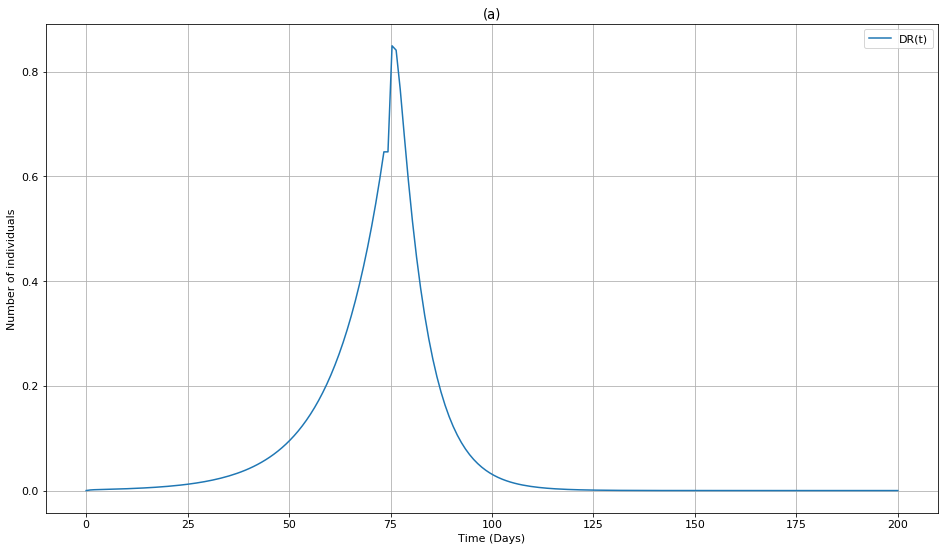

In [24]:
plt.rcParams['figure.figsize'] = 16, 9       # Aspect ratio of the figures

plt.figure()
plt.plot(t, dr, label = "DR(t)")
plt.grid()
plt.xlabel("Time (Days)")
plt.ylabel("Number of individuals")
plt.title("(a)")
plt.legend(loc = 0)

plt.savefig('dr.png')